In [1]:
from Bagging import create_models, create_bags, evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import random
from BaggingSA import BaggingSA

seed = 41
np.random.seed(seed)
random.seed(seed)

In [2]:
from typing import Tuple
import sklearn


def get_dataset(dataset_name: str) -> Tuple[np.ndarray, np.ndarray]:
    if dataset_name == 'digits':
        data = sklearn.datasets.load_digits()
        X = data.data
        y = data.target
        
    elif dataset_name == 'wine':
        data = sklearn.datasets.load_wine()
        X = data.data
        y = data.target
    
    elif dataset_name == 'breast_cancer':
        data = sklearn.datasets.load_breast_cancer()
        X = data.data
        y = data.target
        
    elif dataset_name == 'pima':
        data = pd.read_csv("./../datasets/pima.csv")
        X = data.iloc[:, :-1].values
        y = data.iloc[:, -1].values
    
    else:
        raise ValueError("Unsupported dataset")
    return X, y


X,y = get_dataset('digits')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
def evaluate_bagging_sa():
    bagging_sa = BaggingSA(X=X_train, y=y_train,
                                T0=2.0, alpha=0.995, cooling_method= 'geometric', max_iterations=2000, n_trees=10,
                                fitness_accuracy_diversity_ratio=0.6,
                                feature_mutation_chance=0.1, test_split_amount=20)
    models, fitness = bagging_sa.run(X_for_test=X_test, y_for_test=y_test, monitor_fun=fun_monitor, get_fitness=True)
    accuracy = evaluate(X_test, y_test, models=models)
    return accuracy, models, fitness


fit_acc_sum = {}
run_through_res = []
def fun_monitor(iteration, T, best_fitness, fitness, new_fitness, accuracy):
    if accuracy is None:
        accuracy = 0.0
    
    print(f"I: {iteration}, T: {T:.3f}, Best fitness: {best_fitness:.3f}, Fitness: {fitness:.3f}, New fitness: {new_fitness:.3f}, Accuracy: {accuracy:.3f}")
    if new_fitness not in fit_acc_sum:
        fit_acc_sum[new_fitness] = [accuracy]
    else:
        fit_acc_sum[new_fitness].append(accuracy)
    run_through_res.append([iteration, T, best_fitness, fitness, new_fitness, accuracy])
    global diff_sum

acc_sa, models, fitness_sa = evaluate_bagging_sa()
df = pd.DataFrame(run_through_res, columns=['Iteration', 'T', 'BestFitness', 'Fitness', 'NewFitness', 'Accuracy'])

df.to_csv('./../res/bagging_sa_detail_geometric.csv', index=False)


I: 1, T: 2.000, Best fitness: 0.944, Fitness: 0.944, New fitness: 0.947, Accuracy: 0.894
I: 2, T: 1.990, Best fitness: 0.947, Fitness: 0.947, New fitness: 0.912, Accuracy: 0.864
I: 3, T: 1.980, Best fitness: 0.947, Fitness: 0.912, New fitness: 0.938, Accuracy: 0.883
I: 4, T: 1.970, Best fitness: 0.947, Fitness: 0.938, New fitness: 0.902, Accuracy: 0.892
I: 5, T: 1.960, Best fitness: 0.947, Fitness: 0.902, New fitness: 0.948, Accuracy: 0.889
I: 6, T: 1.950, Best fitness: 0.948, Fitness: 0.948, New fitness: 0.911, Accuracy: 0.881
I: 7, T: 1.941, Best fitness: 0.948, Fitness: 0.911, New fitness: 0.887, Accuracy: 0.875
I: 8, T: 1.931, Best fitness: 0.948, Fitness: 0.887, New fitness: 0.888, Accuracy: 0.853
I: 9, T: 1.921, Best fitness: 0.948, Fitness: 0.888, New fitness: 0.876, Accuracy: 0.856
I: 10, T: 1.912, Best fitness: 0.948, Fitness: 0.876, New fitness: 0.944, Accuracy: 0.856
I: 11, T: 1.902, Best fitness: 0.948, Fitness: 0.944, New fitness: 0.951, Accuracy: 0.864
I: 12, T: 1.893, Be

In [4]:
print("++==============================")
print(f"|| Fitness:  {fitness_sa:.3f}")
print(f"|| Accuracy: {acc_sa:.3f}")
print("++==============================")


++==============================
|| Fitness:  0.957
|| Accuracy: 0.878
++==============================


In [5]:
from Bagging import predict

for i, model in enumerate(models):
    y_pred = predict(X_test, [model])
    acc = accuracy_score(y_test, y_pred)
    print(f"Model [{i}] accuracy: {acc:.3f}")


Model [0] accuracy: 0.606
Model [1] accuracy: 0.597
Model [2] accuracy: 0.658
Model [3] accuracy: 0.575
Model [4] accuracy: 0.600
Model [5] accuracy: 0.550
Model [6] accuracy: 0.611
Model [7] accuracy: 0.608
Model [8] accuracy: 0.697
Model [9] accuracy: 0.628


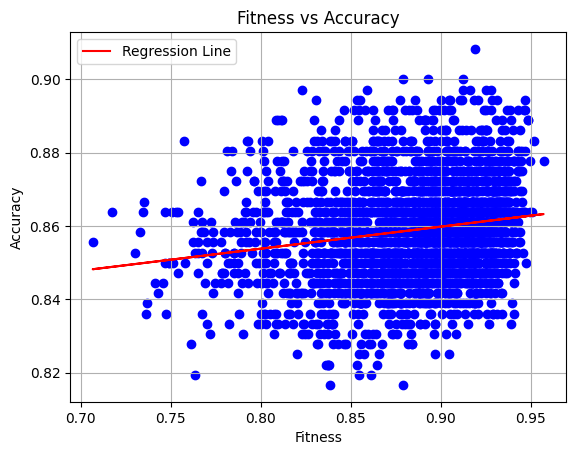

Correlation between fitness and accuracy: 0.184


In [6]:
import matplotlib.pyplot as plt

X = np.array(list(fit_acc_sum.keys()))
Y = np.array([np.mean(fit_acc_sum[x]) for x in X])

coefficients = np.polyfit(X, Y, 1) 
regression_line = np.poly1d(coefficients)

Y_regression = regression_line(X)

plt.scatter(X, Y, color="blue")
plt.plot(X, Y_regression, label="Regression Line", color="red")


plt.xlabel("Fitness")
plt.ylabel("Accuracy")
plt.title("Fitness vs Accuracy")
plt.grid()
plt.legend()
# plt.savefig('./../res/bagging_sa_detail_geometric_correlation.png')
plt.show()

correlation = np.corrcoef(X, Y)[0, 1]

print(f"Correlation between fitness and accuracy: {correlation:.3f}")


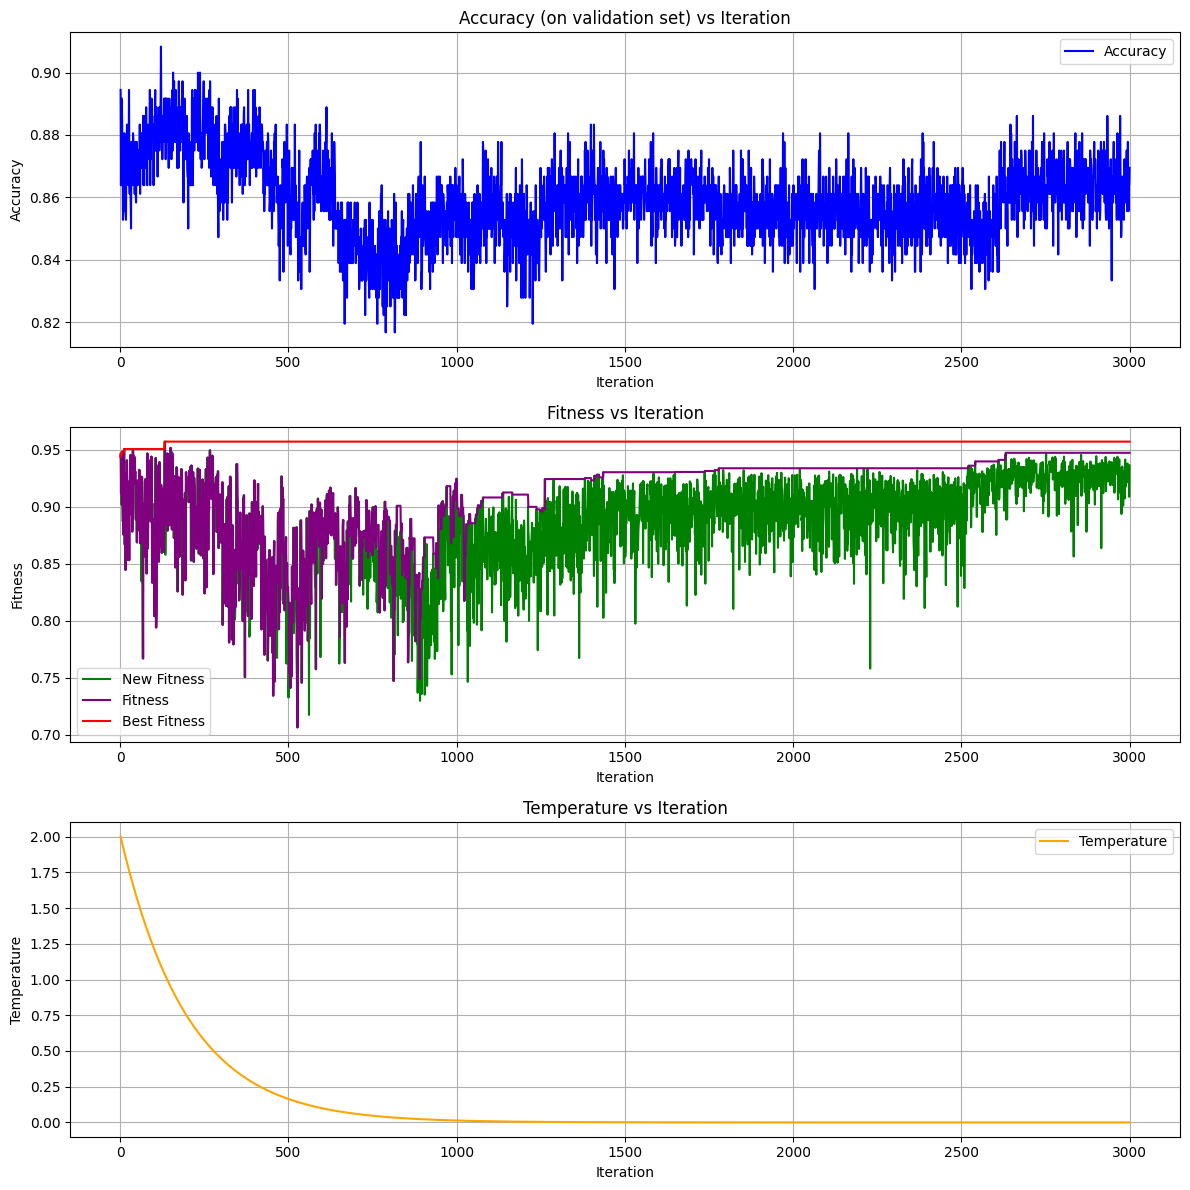

In [7]:
X = df['Iteration']

Y1 = df['Accuracy']

Y2 = df['NewFitness']
Y2_2 = df['BestFitness']
Y2_3 = df['Fitness']

Y3 = df['T']

fig, axs = plt.subplots(3, 1, figsize=(12, 12))
axs[0].plot(X, Y1, label="Accuracy", color="blue")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Accuracy (on validation set) vs Iteration")
axs[0].grid()   
axs[0].legend()

axs[1].plot(X, Y2, label="New Fitness", color="green")
axs[1].plot(X, Y2_3, label="Fitness", color="purple")
axs[1].plot(X, Y2_2, label="Best Fitness", color="red")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Fitness")
axs[1].set_title("Fitness vs Iteration")
axs[1].grid()
axs[1].legend()


axs[2].plot(X, Y3, label="Temperature", color="orange")
axs[2].set_xlabel("Iteration")
axs[2].set_ylabel("Temperature")
axs[2].set_title("Temperature vs Iteration")
axs[2].grid()
axs[2].legend()

plt.tight_layout()
# plt.savefig('./../res/bagging_sa_detail_geometric.png')

plt.show()